In [2]:
import numpy as np 
import torch

At first we have : 
- first camera parameters -> A (focal, etc) 
- rotation  -> R 
- position - C ou T ?  matrix
- 3D points position ->  P1 P2 P3 

In [5]:
# This script defines the camera parameters, rotation matrix, and translation matrix.
def camera() : 
  # Definition of the camera parameters
  # focal length
  fx = 60
  fy = 40
  # center
  cx = 0
  cy = 0

  A = torch.tensor([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]) # intraseca matrix of the camera (3*3)
  #A = torch.from_numpy(A)  # Convert to a PyTorch tensor
  print("A = \n", A)
  return A

A = camera() 


def rotation_matrix() : 
  # Definition of the rotation matrix of the camera 
  R = torch.tensor([[1, 0, 0],[0, -1, 0], [0, 0, -1]])
  #R = torch.from_numpy(R)  # Convert to a PyTorch tensor
  print("R = \n",R)
  return R

def camera_position() : 
  # Definition of the translation matrix of the camera (the position)
  C = torch.tensor([[0,0,6]])    # T = [tx,ty,tz]  (1*3)
  #C = torch.from_numpy(C)    # Convert to a PyTorch tensor
  #C = C.reshape((3,1))                       # (3*1)
  print("C = \n",C)
  return C

R = rotation_matrix()
C = camera_position()

A = 
 tensor([[60,  0,  0],
        [ 0, 40,  0],
        [ 0,  0,  1]])
R = 
 tensor([[ 1,  0,  0],
        [ 0, -1,  0],
        [ 0,  0, -1]])
C = 
 tensor([[0, 0, 6]])


In [72]:
# Definition of 3D points in the world coordinate system
def point3Daleatoire(x) :
  # Generation of one random points in 3D space 
  return torch.tensor([[np.random.uniform(-x,x),np.random.uniform(-x,x),np.random.uniform(-x,x)]])

def pts_3D_4pts():
  # Generate randomly 4 3D points
  # Output : array which concatenate the 4 points = [ P1, P2, P3, P4 ] 

  P1 = point3Daleatoire(2)     # (1*3) -> pour P3P
  P2 = point3Daleatoire(2)
  P3 = point3Daleatoire(2)
  P4 = point3Daleatoire(2)
  
  points3D = torch.cat((P1,P2,P3,P4),dim=0);     # (LIGNES 4* COLONNES 3) - xyz
  print("points3D = \n", points3D)
  return points3D

P1 = torch.tensor([0.7161, 0.5431, 1.7807], dtype=torch.float64)
P2 = torch.tensor([-1.1643, 0.8371, -1.0551], dtype=torch.float64)
P3 = torch.tensor([-1.5224, 0.4292, -0.1994], dtype=torch.float64)

print("P1 = \n", P1)
print("P2 = \n", P2)
print("P3 = \n", P3)

P1 = 
 tensor([0.7161, 0.5431, 1.7807], dtype=torch.float64)
P2 = 
 tensor([-1.1643,  0.8371, -1.0551], dtype=torch.float64)
P3 = 
 tensor([-1.5224,  0.4292, -0.1994], dtype=torch.float64)


We create the 3 direction features vectors f1, f2, f3

In [73]:
def features_vectors(points3D,C) :
    '''
    This function computes the features vectors for P3P algorithm.
    args:
    points3D : array with the 4 3D points = [ P1, P2, P3, P4 ] (4*3) 
    but we only use the first three points for P3P
    C: camera position matrix : (3*1)
    returns:
    featuresVect : array with the features vectors (9*1)
    '''
    P1 = points3D[0]
    P2 = points3D[1]
    P3 = points3D[2]

    f1 = (P1 - C) /torch.norm(P1 - C)
    f2 = (P2 - C) / torch.norm(P2 - C)
    f3 = (P3 - C) / torch.norm(P3 - C)
    
    featuresVect = torch.cat((f1,f2,f3),dim=0)
    print("features vectors = \n",featuresVect)

    return featuresVect # Return the features vectors need in P3P


points3D = [P1, P2, P3]  # We define the points3D with the first three points
print("points3D = \n", points3D)  # Print the points3D to check the values
#print(points3D[:3,:]) # we print the first three columns of points3D to check the shape
featuresVect = features_vectors(points3D, C)  # call the function to get the features vectors OK

points3D = 
 [tensor([0.7161, 0.5431, 1.7807], dtype=torch.float64), tensor([-1.1643,  0.8371, -1.0551], dtype=torch.float64), tensor([-1.5224,  0.4292, -0.1994], dtype=torch.float64)]
features vectors = 
 tensor([[ 0.1660,  0.1259, -0.9781],
        [-0.1617,  0.1163, -0.9800],
        [-0.2379,  0.0671, -0.9690]], dtype=torch.float64)


Lastly we need the functions to resolve the polynomial roots. - for test go to test resolution polynome 

In [74]:
import math

def sqrt_3(x):
    # Assumes x is a tensor (real or complex)
    x_real = torch.real(x)

    # Create mask for positive real part
    positive_mask = x_real >= 0

    # Handle both cases using torch.where
    return torch.where(positive_mask, x**(1/3), -(-x)**(1/3))

def polynomial_root_calculation_3rd_degree(a, b, c, d):
    # Convert to complex tensors
    a = torch.tensor(a, dtype=torch.complex64)
    b = torch.tensor(b, dtype=torch.complex64)
    c = torch.tensor(c, dtype=torch.complex64)
    d = torch.tensor(d, dtype=torch.complex64)

    # Discriminant terms
    p = (3 * a * c - b**2) / (3 * a**2)
    q = (2 * b**3 - 9 * a * b * c + 27 * a**2 * d) / (27 * a**3)
    delta = -4 * p**3 - 27 * q**2

    roots = []

    j_ = torch.exp(2j * math.pi / 3)  # cube root of unity

    for k in range(3):
        com = -delta / 27
        sqrt_term = torch.sqrt(com.to(torch.complex64))

        u_k = j_**k * sqrt_3(0.5 * (-q + sqrt_term))
        v_k = j_**(-k) * sqrt_3(0.5 * (-q - sqrt_term))

        root = u_k + v_k - b / (3 * a)
        roots.append(root)

    return torch.stack(roots)


def polynomial_root_calculation_4th_degree_ferrari(a): # Ferrari's Method
    # Solving a polynomial of 4th degree

    # Input : array 5*1 with the 5 coefficiants of the polynomial 
    # Output : roots of the polynomial a[4]*x^4 + a[3]*x^3 + a[2]*x^2 + a[1]*x + a[0]   -> array : [x1,x2,x3,x4]  (4*1)

    if torch.shape(a)[0] != 5 :
      print("Expeted 5 coefficiants for a 4th order polynomial")
      return

    a0, a1, a2, a3, a4 = a

    # Reduce the quartic equation to the form : x^4 + a*x^3 + b*x^2 + c*x + d = 0
    a = a3/a4
    b = a2/a4
    c = a1/a4
    d = a0/a4

    # Computation of the coefficients of the Ferrari's Method
    S = a/4
    b0 = d - c*S + b* S**2 - 3* S**4
    b1 = c - 2*b*S + 8*S**3
    b2 = b - 6 * S**2


    # Solve the cubic equation m^3 + b2*m^2 + (b2^2/4  - b0)*m - b1^2/8 = 0
    x_cube = polynomial_root_calculation_3rd_degree(1,b2,(b2**2)/4-b0,(-b1**2)/8)

    # Find a real and positive solution
    alpha_0 = 0
    for r in x_cube :
      if torch.isclose(torch.imag(r),torch.tensor(0.0),atol=1e-7) and torch.real(r) > 0 :
        alpha_0 = r
        
    def torch_sqrt(x):
        return torch.sqrt(x.to(torch.complex64))

    if alpha_0 != 0:
        sqrt_alpha = torch.sqrt(alpha_0 / 2)
        term = -alpha_0 / 2 - b2 / 2
        denom = 2 * torch.sqrt(2 * alpha_0)

        x1 = sqrt_alpha - S + torch_sqrt(term - b1 / denom)
        x2 = sqrt_alpha - S - torch_sqrt(term - b1 / denom)
        x3 = -sqrt_alpha - S + torch_sqrt(term + b1 / denom)
        x4 = -sqrt_alpha - S - torch_sqrt(term + b1 / denom)
    else:
        sqrt_inner1 = torch_sqrt((b2**2) / 4 - b0)
        x1 = -S + torch_sqrt(-b2 / 2 + sqrt_inner1)
        x2 = -S - torch_sqrt(-b2 / 2 + sqrt_inner1)
        x3 = -S + torch_sqrt(-b2 / 2 - sqrt_inner1)
        x4 = -S - torch_sqrt(-b2 / 2 - sqrt_inner1)

    return torch.cat([x1, x2, x3, x4])

We have all the variables needed for the p3p so we start

1. on stocke les points : c'est fait

In [75]:
print(P1, P2, P3)

tensor([0.7161, 0.5431, 1.7807], dtype=torch.float64) tensor([-1.1643,  0.8371, -1.0551], dtype=torch.float64) tensor([-1.5224,  0.4292, -0.1994], dtype=torch.float64)


2. Stpockage des features vectors : fait

In [76]:
# we got featuresVect and we access the 3 values 
f1 = featuresVect[0]
f2 = featuresVect[1]
f3 = featuresVect[2]

print("f1 = ", f1)
print("f2 = ", f2)
print("f3 = ", f3)

f1 =  tensor([ 0.1660,  0.1259, -0.9781], dtype=torch.float64)
f2 =  tensor([-0.1617,  0.1163, -0.9800], dtype=torch.float64)
f3 =  tensor([-0.2379,  0.0671, -0.9690], dtype=torch.float64)


3. on créer la variable de solution, au maximum on a 4 solutions, on a la (3,1) qui contiendra C et (3,3) contiendra R 

In [78]:
solutions = torch.zeros((4,3,4), dtype=torch.float64)
print("solutions = \n", solutions)

solutions = 
 tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float64)


4. On teste si les 3 points ne sont pas colinéaires

In [79]:
# Test of non-collinearity
v1 = P2 - P1
v2 = P3 - P1
if torch.norm(torch.cross(v1,v2))==0 :
    print('Problem: the points must not be collinear')
else:
    print('The points are not collinear, we can continue')

The points are not collinear, we can continue


5. On crée un repère orthonormée à partir de f1, f2, f3

In [80]:
# Calculation of vectors of the base τ = (C,tx,ty,tz)
tx = f1     
print("tx = ", tx)
tz = torch.cross(f1,f2)/torch.norm(torch.cross(f1,f2))
print("tz = ", tz)
ty = torch.cross(tz,tx)
print("ty = ", ty)

tx =  tensor([ 0.1660,  0.1259, -0.9781], dtype=torch.float64)
tz =  tensor([-0.0298,  0.9920,  0.1226], dtype=torch.float64)
ty =  tensor([-0.9857, -0.0088, -0.1684], dtype=torch.float64)


tx = tensor([ 0.1660,  0.1259, -0.9781], dtype=torch.float64)
ty = tensor([-0.9857, -0.0088, -0.1684], dtype=torch.float64)
tz = tensor([-0.0298,  0.9920,  0.1226], dtype=torch.float64)

Vérification orthogonalité :
tx · ty = -2.7755575615628914e-17
tx · tz = -1.3877787807814457e-17
ty · tz = -3.469446951953614e-18


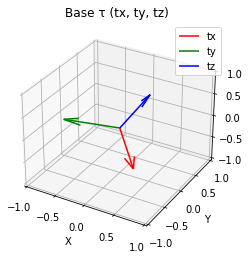

In [81]:
import numpy as np
import matplotlib.pyplot as plt
print("tx =", tx)
print("ty =", ty)
print("tz =", tz)

print("\nVérification orthogonalité :")
print("tx · ty =", np.dot(tx, ty))
print("tx · tz =", np.dot(tx, tz))
print("ty · tz =", np.dot(ty, tz))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

origin = np.zeros(3)

ax.quiver(*origin, *tx, color='r', label='tx')
ax.quiver(*origin, *ty, color='g', label='ty')
ax.quiver(*origin, *tz, color='b', label='tz')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Base τ (tx, ty, tz)')
ax.legend()
plt.show()


5.bis On crée la matrice de transformation T  

In [82]:
tx = torch.reshape(tx,(1,3))   # (1*3)
ty = torch.reshape(ty,(1,3))
tz = torch.reshape(tz,(1,3))

# Computation of the matrix T and the feature vector f3
T = torch.cat((tx,ty,tz),dim = 0) # (3*3)
f3_T = torch.tensordot(T,f3, dims=1) # (3,)

print("tx = \n", tx)
print("ty = \n", ty)
print("tz = \n", tz)
print("f3_T = \n", f3_T)
print("T = \n", T)

tx = 
 tensor([[ 0.1660,  0.1259, -0.9781]], dtype=torch.float64)
ty = 
 tensor([[-0.9857, -0.0088, -0.1684]], dtype=torch.float64)
tz = 
 tensor([[-0.0298,  0.9920,  0.1226]], dtype=torch.float64)
f3_T = 
 tensor([ 0.9166,  0.3971, -0.0452], dtype=torch.float64)
T = 
 tensor([[ 0.1660,  0.1259, -0.9781],
        [-0.9857, -0.0088, -0.1684],
        [-0.0298,  0.9920,  0.1226]], dtype=torch.float64)


Il faut satisfaire la condition que z dans f3_T est négative, sinon on inverse l'ordre des vecteur afin de .... 

In [83]:
# Having teta in [ 0, pi ] 
if f3_T[2] > 0 :
    # We have teta in [ 0, pi ]
    f1 = featuresVect[1]
    print("f1 = ", f1)
    f2 = featuresVect[0]
    print("f2 = ", f2)
    f3 = featuresVect[2]
    print("f3 = ", f3)


    # RE calculation of vectors of the base τ = (C,tx,ty,tz) to ensure orthogonality
    tx = f1         # (3,)
    tz = torch.cross(f1,f2)/torch.norm(torch.cross(f1,f2), dim=0)  # (3,)
    ty = torch.cross(tz,tx)

    tx = torch.reshape(tx,(1,3))   # (1*3)
    prin("tx = \n", tx)
    ty = torch.reshape(ty,(1,3))
    print("ty = \n", ty)
    tz = torch.reshape(tz,(1,3))
    print("tz = \n", tz)

    # Computation of the matrix T and the feature vector f3
    T = torch.cat((tx,ty,tz),dim = 0) # (3*3)
    print("T = \n", T) 
    f3_T= torch.tensordot(T,f3, dims=1) # (3,)

6. on change de base du coté des points 3D

In [84]:
# Calculation of vectors of the base η = (P1,nx,ny,nz)
nx = (P2 - P1)/torch.norm(P2 - P1)      #(3,)
nz = torch.cross(nx,P3-P1)/torch.norm(torch.cross(nx,P3-P1), dim=0)  
ny = torch.cross(nz,nx)
print("nx = ", nx)
print("ny = ", ny)
print("nz = ", nz)

# Reshape the vectors to (1,3) for concatenation
nx = torch.reshape(nx,(1,3))  # (1,3)
ny = torch.reshape(ny,(1,3))
nz = torch.reshape(nz,(1,3))
print("nx = \n", nx)
print("ny = \n", ny)
print("nz = \n", nz)

# Computation of the matrix N and the world point P3
N = torch.cat((nx,ny,nz),dim = 0) # (3*3) T's equivalent in the world coordinate system
print(N.shape)
print((P3-P1).dtype)
print("CC",P3-P1)

P3_n = torch.tensordot(N,P3-P1, dims=1) # (3,)

print("N = \n", N)
print("P3_n = \n", P3_n)

nx =  tensor([-0.5506,  0.0861, -0.8303], dtype=torch.float64)
ny =  tensor([-0.7747, -0.4233,  0.4698], dtype=torch.float64)
nz =  tensor([-0.3110,  0.9019,  0.2998], dtype=torch.float64)
nx = 
 tensor([[-0.5506,  0.0861, -0.8303]], dtype=torch.float64)
ny = 
 tensor([[-0.7747, -0.4233,  0.4698]], dtype=torch.float64)
nz = 
 tensor([[-0.3110,  0.9019,  0.2998]], dtype=torch.float64)
torch.Size([3, 3])
torch.float64
CC tensor([-2.2385, -0.1139, -1.9801], dtype=torch.float64)
N = 
 tensor([[-0.5506,  0.0861, -0.8303],
        [-0.7747, -0.4233,  0.4698],
        [-0.3110,  0.9019,  0.2998]], dtype=torch.float64)
P3_n = 
 tensor([2.8668, 0.8521, 0.0000], dtype=torch.float64)


7. On définit des variable pour la suite

In [ ]:
# Computation of phi1 et phi2 with 0=x, 1=y, 2=z
phi1 = f3_T[0]/f3_T[2]
phi2 = f3_T[1]/f3_T[2]
print("phi1 = ", phi1)
print("phi2 = ", phi2)

# Extraction of p1 and p2 from P3_eta
p1 = P3_n[0] #x
p2 = P3_n[1] #y
print("p1 = ", p1)
print("p2 = ", p2)

# Computation of d12
d12 = torch.norm(P2-P1)
print("d12 = ", d12)

# Computation of b = cot(beta)
cosBeta = torch.dot(f1,f2)/(np.linalg.norm(f1)*np.linalg.norm(f2)) 
print("cosBeta = ", cosBeta)  
b = np.sqrt(1/(1-cosBeta**2)-1)

if cosBeta < 0 :
    b = -b
print("b = ", b)

phi1 =  -20.29127378614751
phi2 =  -8.791396593921803
p1 =  2.8668136593135083
p2 =  0.8520744760720703
d12 =  3.4152747766468217
cosBeta =  0.9462521400867492
b =  2.9256794072780483


In [16]:
a4 = - phi2**2 * p2**4 - phi1**2 * p2**4 - p2**4
a3 = 2 * p2**3 * d12 * b + 2 * phi2**2 * p2**3 * d12 * b - 2 * phi1 * phi2 * p2**3 * d12
a2 = - phi2**2 * p1**2 * p2**2 - phi2**2 * p2**2 * d12**2 * b**2 - phi2**2 * p2**2 * d12**2 + phi2**2 * p2**4 + phi1**2 * p2 **4 + 2 * p1 * p2**2 * d12 + 2 * phi1 * phi2 * p1 * p2**2 * d12 * b - phi1**2 * p1**2 * p2**2 + 2 * phi2**2 * p1 * p2**2 * d12 - p2**2 * d12**2 * b**2 - 2 * p1**2 * p2**2
a1 = 2 * p1**2 * p2 * d12 * b + 2 * phi1 * phi2 * p2**3 * d12 - 2 * phi2**2 * p2**3 * d12 * b - 2 * p1 * p2 * d12**2 * b
a0 = - 2 * phi1 * phi2 * p1 * p2**2 * d12 * b + phi2**2 * p2**2 * d12**2 + 2 * p1**3 * d12 - p1**2 * d12**2 + phi2**2 * p1**2 * p2**2 - p1**4 - 2 * phi2**2 * p1 * p2**2 * d12 + phi1**2 * p1**2 * p2**2 + phi2**2 * p2**2 * d12**2 * b**2

print("a4 = ", a4)
print("a3 = ", a3)
print("a2 = ", a2)
print("a1 = ", a1)
print("a0 = ", a0)


a4 =  -258.3021202517885
a3 =  214.06407775251841
a2 =  -468.54012904994937
a1 =  -228.47483485047505
a0 =  653.6390577906441


In [17]:
# Computation of the roots
roots = polynomial_root_calculation_4th_degree_ferrari(np.array([a0,a1,a2,a3,a4])) # (4,)

print("roots = \n", roots)

roots = 
 [ 0.4313253 +1.60436442j  0.4313253 -1.60436442j  0.94071362+0.j
 -0.97462895-0.j        ]


In [20]:
# For each solution of the polynomial
for i in range(4):
  #if np.isclose(np.imag(roots[i]),0) : # if real solution 

    # Computation of trigonometrics forms
    cos_teta = np.real(roots[i])
    sin_teta = np.sqrt(1-cos_teta**2)

    cot_alpha = ((phi1/phi2)*p1 + cos_teta*p2 -d12*b )/ ((phi1/phi2)*cos_teta* p2 - p1 + d12)

    sin_alpha = np.sqrt(1/(cot_alpha**2+1))
    cos_alpha= np.sqrt(1-sin_alpha**2)

    if cot_alpha < 0 :
      cos_alpha = -cos_alpha

    # Computation of the intermediate rotation's matrixs
    C = [d12*cos_alpha*(sin_alpha*b + cos_alpha), d12*sin_alpha*cos_teta*(sin_alpha*b+cos_alpha), d12*sin_alpha*sin_teta*(sin_alpha*b+cos_alpha)]     # (3,)
    Q = [[-cos_alpha, -sin_alpha*cos_teta, -sin_alpha*sin_teta], [sin_alpha, -cos_alpha*cos_teta, -cos_alpha*sin_teta], [0, -sin_teta, cos_teta]]      # (3*3)

    # Computation of the absolute camera center
    C = P1 + np.transpose(N) @ C  # (3,)
    C = C[:,np.newaxis]   # (3,1)

    # Computation of the orientation matrix
    R = np.transpose(N) @ np.transpose(Q) @ T   # (3*3)

    # Adding C and R to the solutions
    solutions[i,:,:1]= C
    solutions[i,:,1:] = R




In [21]:
print("solutions = \n", solutions)

solutions = 
 [[[ 9.83224841e-01  7.21398703e-01  5.36922132e-01  4.37376880e-01]
  [ 7.51679051e-01 -6.54088592e-01  7.35743066e-01  1.75642405e-01]
  [ 2.83875073e+00 -2.27490712e-01 -4.12791431e-01  8.81958735e-01]]

 [[ 9.83224841e-01  7.21398703e-01  5.36922132e-01  4.37376880e-01]
  [ 7.51679051e-01 -6.54088592e-01  7.35743066e-01  1.75642405e-01]
  [ 2.83875073e+00 -2.27490712e-01 -4.12791431e-01  8.81958735e-01]]

 [[ 1.02140518e-14  1.00000000e+00  5.08993741e-15  2.38264186e-15]
  [ 2.03170814e-14 -5.06323217e-15  1.00000000e+00  3.61729435e-15]
  [ 6.00000000e+00 -2.37109070e-15 -3.65269861e-15  1.00000000e+00]]

 [[-1.25864955e+00  8.47829541e-01  5.19199262e-01 -1.07783094e-01]
  [ 2.26707244e+00  5.27913852e-01 -8.07308662e-01  2.63741710e-01]
  [-3.99101139e+00  4.99202756e-02 -2.80508201e-01 -9.58552615e-01]]]


In [ ]:
def projection3D2D(point3D,C,R,A) :
  # 3D point = [ Xw, Yw, Zw ]'   (1*3)
  # T : camera translation matrix : (3*1)
  # R : camera rotation matrix : (3*3)
  # A : intraseca matrix of the camera : (3*3)
  # Output : return the coordonates of the point in 2D 

  PI = np.concatenate((np.eye(3),np.zeros((3,1))),axis=1)  # (3*4)
  
  Rt = np.concatenate((R,C),axis=1)               # (3*4)
  Rt = np.concatenate((Rt,np.array([[0,0,0,1]])),axis=0)   # (4*4)

  point3D_bis = np.concatenate((np.reshape(point3D,(3,1)),np.array([[1]])),axis=0)   #(4*1)
 
  point2D = A @ PI @ Rt @ point3D_bis   # 2D point = [u, v, w] (3*1)
  point2D = point2D / point2D[2]        # 2D point = [u, v, 1] (3*1)
  return point2D[:2]


# Example usage of the projection function
p1 = projection3D2D(points3D[0],C,R,A)
print("p1 = ", p1)
p2 = projection3D2D(points3D[1],C,R,A)
print("p2 = ", p2)
p3 = projection3D2D(points3D[2],C,R,A)
print("p3 = ", p3)
P4 = np.array([-1.5224, 0.4292, -0.1994])
p4 = projection3D2D(P4,C,R,A)
print("p4 = ", p4)
new_points3D = np.concatenate((points3D, P4.reshape(1, 3)), axis=0)



p1 =  [[  5.7938345 ]
 [-18.41125529]]
p2 =  [[31.12103871]
 [-8.53578256]]
p3 =  [[ 34.60807743]
 [-10.65283124]]
p4 =  [[ 34.60807743]
 [-10.65283124]]


In [34]:
def distance(pt, pt_estimation):
    erreur = 0
    for i in range(len(pt)):
      erreur += (pt[i] - pt_estimation[i])**2
    return np.sqrt(erreur)



def affichage_erreur(solutions,points2D,points3D,A) : 
   # Compute the error of estimation for each points after the P3P algorithm 

   # solutions : solution matrix returned by P3P (4*3*4)
   # points 3D : 4 pts 3D used for P3P 
   # points 2D : 4 pts 2D used for P3P (image of the 3D points)
   
   P1 = points3D[0]
   P2 = points3D[1]
   P3 = points3D[2]
   P4 = points3D[3]

   erreurs = []
   nb_sol = 0

   for i in range(len(solutions)) : 
      R = solutions[i,:,1:] 
      C = solutions[i,:,:1]

      if not np.all(R==np.zeros((3,3))) : 
        nb_sol += 1 
        print("------------ Solution n° : ",nb_sol,"----------------")
        print("R = \n",R,)
        print("T = \n",C,)

        p1_P3P = np.reshape(projection3D2D(P1,C,R,A),(1,2))
        p2_P3P = np.reshape(projection3D2D(P2,C,R,A),(1,2))
        p3_P3P = np.reshape(projection3D2D(P3,C,R,A),(1,2))
        p4_P3P = np.reshape(projection3D2D(P4,C,R,A),(1,2))
        pt_2D_P3P = np.concatenate((p1_P3P,p2_P3P,p3_P3P,p4_P3P),axis=0)    # (4,2)

        erreurs.append([0])
        for j in range(len(points2D)):
            erreur_pt = distance(points2D[j],pt_2D_P3P[j])
            print("erreur_pt",j," = ",erreur_pt)
            erreurs[i]+=erreur_pt
        
   indice_min = 0
   min = erreurs[0]
   for i in range(1,len(erreurs)) :
    if erreurs[i]<min :
      min = erreurs[i]
      indice_min = i

   R_opti = solutions[indice_min,:,1:] 
   C_opti = solutions[indice_min,:,:1]
   print("\n------------ Best solution : ----------------")
   print("Solution n° :",indice_min+1,"\n")
   print("R estimé = \n", R_opti,"\n")
   print("T estimé = \n", C_opti, "\n")

In [35]:
affichage_erreur(solutions, [p1, p2, p3, p4], new_points3D, A)

------------ Solution n° :  1 ----------------
R = 
 [[ 0.7213987   0.53692213  0.43737688]
 [-0.65408859  0.73574307  0.17564241]
 [-0.22749071 -0.41279143  0.88195873]]
T = 
 [[0.98322484]
 [0.75167905]
 [2.83875073]]
erreur_pt 0  =  [43.13882519]
erreur_pt 1  =  [57.68967664]
erreur_pt 2  =  [51.97281155]
erreur_pt 3  =  [51.97281155]
------------ Solution n° :  2 ----------------
R = 
 [[ 0.7213987   0.53692213  0.43737688]
 [-0.65408859  0.73574307  0.17564241]
 [-0.22749071 -0.41279143  0.88195873]]
T = 
 [[0.98322484]
 [0.75167905]
 [2.83875073]]
erreur_pt 0  =  [43.13882519]
erreur_pt 1  =  [57.68967664]
erreur_pt 2  =  [51.97281155]
erreur_pt 3  =  [51.97281155]
------------ Solution n° :  3 ----------------
R = 
 [[ 1.00000000e+00  5.08993741e-15  2.38264186e-15]
 [-5.06323217e-15  1.00000000e+00  3.61729435e-15]
 [-2.37109070e-15 -3.65269861e-15  1.00000000e+00]]
T = 
 [[1.02140518e-14]
 [2.03170814e-14]
 [6.00000000e+00]]
erreur_pt 0  =  [21.20503283]
erreur_pt 1  =  [47.76